
## Содержание<a class="tocSkip">

1. [Изучение данных из файла](#opening)
    - [Вывод](#opening_conclusion)
    
    
2. [Предобработка данных](#preprocessing)
    - [Вывод](#preprocessing_conclusion)  
        
 
3. [Анализ данных](#analysis)
    - [Cоотношение видов объектов общественного питания по количеству](#types_by_count)
    - [Cоотношение сетевых и несетевых заведений по количеству](#chain_by_count)
    - [Cоотношение видов сетевых и несетевых заведений](#type_by_count)
    - [Характеристика сетевых заведений по количеству заведений и количеству посадочных мест в одном заведении](#chain_by_number)
    - [Среднее количество посадочных мест по видам объекта общественного питания](#mean_by_type)
    - [Топ-10 улиц по количеству объектов общественного питания](#10_streets)
    - [Улицы с одним объектом общественного питания](#streets_one_object)
    - [Количество посадочных мест на улицах с большим количеством объектов общественного питания](#seats_top_10_streets)
    - [Вывод](#analysis_conclusion)


5. [Общий вывод](#conclusion)

# Анализ открытых данных о заведениях общественного питания в Москве

<br>
Исследование для инвесторов на основании имеющихся открытых данных о заведениях общественного питания в Москве.

Разработка рекомендаций о виде заведения, количестве посадочных мест, а также районе расположения, рассмотрение возможности развития сети в целях привлечения инвестиций.

<a id="opening"></a>
## Изучение данных из файла

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from io import BytesIO
import requests

Прочитаем имеющийся в нашем распоряжении файл, посмотрим сводную информацию и первые 5 строк.

In [2]:
try:
    rest_data = pd.read_csv(r"/datasets/rest_data.csv")
except FileNotFoundError:
    rest_data = pd.read_csv(r"C:\Users\79822\python\datasets\rest_data.csv")

In [3]:
def description(list_df, list_names): #напишем функцию для краткого описания датафреймов
    assert len(list_df) == len(list_names)
    for num in range(len(list_df)):
        print('Первые 5 строк и сводная информация по файлу', list_names[num])
        display(list_df[num].head())
        list_df[num].info()
        print('Количество строк-дубликатов в датафрейме', list_names[num], 'равно', list_df[num].duplicated().sum())
        print('_'*100)

In [4]:
description([rest_data], ['rest_data'])

Первые 5 строк и сводная информация по файлу rest_data


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
Количество строк-дубликатов в датафрейме rest_data равно 0
____________________________________________________________________________________________________


<a id="opening_conclusion"></a>
### Вывод

В нашем распоряжении датафрейм с открытыми данными о заведениях общественного питания в Москве. Датафрейм содержит информацию о:
- идентификационном номере заведения;
- названии заведения;
- указании, является ли заведение сетевым;
- типе заведения;
- адресе;
- количестве посадочных мест.

Пропуски и дубликаты в датафрейме отсутствуют.

<a id="preprocessing"></a>
## Предобработка данных

Посчитаем, какое количество заведений с пометкой сетевые есть в датафрейме, и какое количество сетей получается при группировке.

In [5]:
print('Количество заведений, помеченных как сетевые:',
      rest_data[rest_data['chain']=='да']['id'].count())
print('Количество заведений с повторяющимися названиями:',
      rest_data[rest_data['chain']=='да']['object_name'].duplicated().sum())

Количество заведений, помеченных как сетевые: 2968
Количество заведений с повторяющимися названиями: 2244


Посчитаем, сколько сетевых заведений не попадут в анализ при группировке по именам и их долю.

In [6]:
print('Количество заведений, которые не попадут в анализ при группировке по именам:',
      rest_data[rest_data['chain']=='да']['id'].count()-\
      rest_data[rest_data['chain']=='да']['object_name'].duplicated().sum())
print('Доля заведений, которые не попадут в анализ при группировке по именам:',
      round((rest_data[rest_data['chain']=='да']['id'].count()-\
      rest_data[rest_data['chain']=='да']['object_name'].duplicated().sum())/\
     rest_data[rest_data['chain']=='да']['id'].count(), 2))

Количество заведений, которые не попадут в анализ при группировке по именам: 724
Доля заведений, которые не попадут в анализ при группировке по именам: 0.24


Для обработки создадим колонку `object_name_lower` , в ней приведем названия заведений к нижнему регистру.

In [7]:
rest_data['object_name_lower'] = rest_data['object_name'].map(str.lower)

Для обработки названий сетевых заведений я подготовила файл `moscow_rest_chains.csv` и разместила его на Гугл Диск. Загрузим данный файл и посмотрим по нему информацию.

In [8]:
spreadsheet_id = '1zjOXFjr1vleQJd3R5mI-5efNCEj2I6DcKE4xlYVcsoU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
rest_chains = pd.read_csv(BytesIO(r.content))
description([rest_chains], ['rest_chains'])

Первые 5 строк и сводная информация по файлу rest_chains


,rest_chain_name
0,Wetzel’s Pretzels
1,1-2-3 кафе
2,33 зуба
3,5 звезд
4,5 оборотов на Калужской


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rest_chain_name  666 non-null    object
dtypes: object(1)
memory usage: 5.3+ KB
Количество строк-дубликатов в датафрейме rest_chains равно 8
____________________________________________________________________________________________________


Датафрейм содержит дубликаты, уберем их и приведем названия сетей к нижнему регистру.

In [9]:
rest_chains = rest_chains.drop_duplicates().reset_index(drop=True)
rest_chains['rest_chain_name'] = rest_chains['rest_chain_name'].map(str.lower)
rest_chains.tail()

,rest_chain_name
653,маки маки / maki maki
654,космик
655,суши вок / sushi wok
656,папа джонс / papa jones
657,поль бейкери


Некоторые сети в файле содержат по два названия, сделаем срез по таким строкам и вынесем их в отдельный датафрейм. Датафрейм превратим в список.

In [10]:
rest_chains_double_names = rest_chains.query(
    'rest_chain_name.str.contains(" / ")')['rest_chain_name'].str.split(' / ', expand=True).reset_index(drop=True)
rest_chains_double_names_list = rest_chains_double_names.values.tolist()
rest_chains_double_names_list

[['amstel bar', 'амстел бар'],
 ['andiamo', 'андиамо'],
 ['bento cafe', 'бенто кафе'],
 ['bocconcino', 'бокончино'],
 ['burger king', 'бургер кинг'],
 ['cafemax', 'кафемакс'],
 ['cantina mariachi', 'кантина мариачи'],
 ["chili's grill & bar", 'чилиз'],
 ['chin chin', 'чин чин'],
 ['city pizza', 'сити пицца'],
 ['da pino', 'да пино'],
 ['de marco', 'де марко'],
 ['don peri', 'дон пери'],
 ['el gaucho', 'эль гаучо'],
 ['eshak', 'ишак'],
 ['fanny pizza', 'фанни пицца'],
 ['fantozzi', 'фантоцци'],
 ['gamberi', 'гамбари'],
 ['goodman', 'гудман'],
 ['grace bar', 'грэйс бар'],
 ['habibi', 'хабиби'],
 ['il camino', 'иль камино'],
 ['il forno', 'иль форно'],
 ['il patio', 'иль патио'],
 ['kitchenette', 'китченетт'],
 ['la mix', 'ла микс'],
 ['laffa laffa', 'лаффа'],
 ['lizarran', 'лизарран'],
 ['london grill', 'лондон гриль'],
 ['luciano', 'лучиано'],
 ['lunchbox', 'ланч бокс'],
 ['max brenner', 'макс бреннер'],
 ['mix cafe', 'микс кафе'],
 ['oskar yard', 'оскар ярд'],
 ['pasta la vista', 'паст

Зададим функцию, которая будет проверять наличие в заданной колонке второго названия сети из датафрейма и, при наличии, заменять его первым.

In [11]:
def double_names(name):
    for double_name in rest_chains_double_names_list:
        if double_name[1] in name:
            return(double_name[0])
    return(name)

Проверим работу функции на датафрейме с названиями сетей.

In [12]:
rest_chains['rest_chain_name'] = rest_chains['rest_chain_name'].map(double_names)
rest_chains.tail()

,rest_chain_name
653,маки маки
654,космик
655,суши вок
656,папа джонс
657,поль бейкери


Функция работает, применим ее для датафрейма с данными о заведениях Москвы. Для обработки выберем только те заведения, у которых в колонке `chain` указано значение "да".

In [13]:
mask = (rest_data['chain']=='да')
rest_data.loc[mask, 'object_name_lower'] = rest_data['object_name_lower'].map(double_names)

Теперь превратим исходный датафрейм с названиями в список названий и напишем функцию для проверки названий заданной колонки: если часть названия заведения соответствует названию сети из списка заменим название заведения названием сети.

In [14]:
rest_chains_list = rest_chains['rest_chain_name'].values.tolist()
def chain_names(name):
    for chain_name in rest_chains_list:
        if chain_name in name:
            return(chain_name)
    return(name)

Применим полученную функцию на датафрейм с данными о заведениях Москвы.

In [15]:
mask = (rest_data['chain']=='да')
rest_data.loc[mask, 'object_name_lower'] = rest_data['object_name_lower'].map(chain_names)

Посмотрим, как изменилась доля заведений, помеченных как сетевые, но с эксклюзивным названием.

In [16]:
print('Количество заведений, которые не попадут в анализ при группировке по именам:',
      rest_data[rest_data['chain']=='да']['id'].count()-\
      rest_data[rest_data['chain']=='да']['object_name_lower'].duplicated().sum())
print('Доля заведений, которые не попадут в анализ при группировке по именам:',
      round((rest_data[rest_data['chain']=='да']['id'].count()-\
      rest_data[rest_data['chain']=='да']['object_name_lower'].duplicated().sum())/\
     rest_data[rest_data['chain']=='да']['id'].count(), 2))

Количество заведений, которые не попадут в анализ при группировке по именам: 363
Доля заведений, которые не попадут в анализ при группировке по именам: 0.12


<a id="preprocessing_conclusion"></a>
### Вывод

Предобработали названия сетевых заведений, при этом количество заведений, помеченных как сетевые, но не имеющих аналогичных названий сократили почти в 2 раза.

При группировке сетевых заведений по именам мы не учтем 12% от общего количества сетевых заведений. Для нашей точности анализа этого будет достаточно.

<a id="analysis"></a>
## Анализ данных

<a id="types_by_count"></a>
### Cоотношение видов объектов общественного питания по количеству

Посмотрим количество разных типов заведений общественного питания.

In [17]:
rest_data.object_type.value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

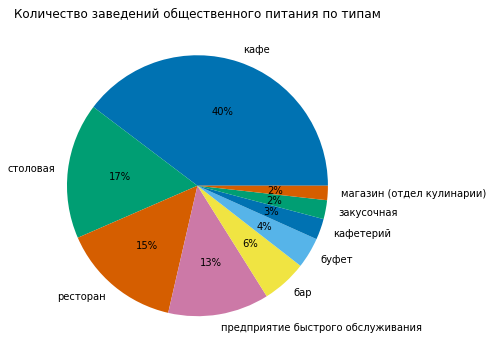

In [18]:
plt.figure(figsize=(6, 6))
with plt.style.context('seaborn-colorblind'):
    plt.pie(rest_data.object_type.value_counts(), labels=rest_data.object_type.value_counts().index, autopct='%1.0f%%')
plt.title('Количество заведений общественного питания по типам')
plt.show()

Больше всего в датасете кафе (6099) - их количество более чем в два раза превосходит следующий тип заведений: столовая (2587). Меньше всего в датасете отделов кулинарии в магазинах (273).

<a id="chain_by_count"></a>
### Cоотношение сетевых и несетевых заведений по количеству

Рассмотрим соотношение сетевых и несетевых заведений по количеству.

In [19]:
rest_data.chain.value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

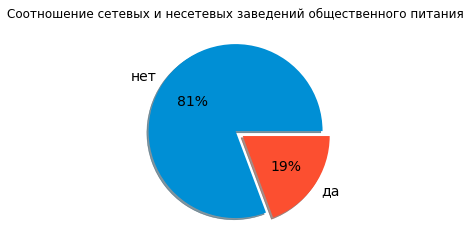

In [20]:
plt.figure(figsize=(4, 4))
with plt.style.context('fivethirtyeight'):
    plt.pie(rest_data.chain.value_counts(), labels=rest_data.chain.value_counts().index, 
            autopct='%1.0f%%', explode=(0, 0.1), shadow=True)
plt.title('Соотношение сетевых и несетевых заведений общественного питания')
plt.show()

В датасете большая часть заведений несетевые (12398).

<a id="type_by_count"></a>
### Cоотношение видов сетевых и несетевых заведений

Определим, для какого вида объекта общественного питания характерно сетевое распространение.

In [21]:
rest_types_by_chain = rest_data.pivot_table(
    index='object_type', columns='chain', values='id', aggfunc='count')
rest_types_by_chain.columns = ['chain', 'not_a_chain']
rest_types_by_chain['chain_persent'] = round(rest_types_by_chain['chain'] / (
    rest_types_by_chain['chain']+rest_types_by_chain['not_a_chain'])*100, 2)
rest_types_by_chain.sort_values(by='chain_persent', ascending=False)

,chain,not_a_chain,chain_persent
object_type,,,
предприятие быстрого обслуживания,791,1132,41.13
магазин (отдел кулинарии),78,195,28.57
ресторан,544,1741,23.81
кафе,1396,4703,22.89
закусочная,56,304,15.56
кафетерий,52,346,13.07
бар,37,819,4.32
буфет,11,574,1.88
столовая,3,2584,0.12


Наибольшая доля сетевых заведений среди предприятий быстрого обслуживания (41%), на втором месте отделы кулинарии в магазинах (29%), на третьем - рестораны (24%), с небольшим отставанием от ресторанов кафе (23%). Наименее распространены сети среди столовых (0.12%).

<a id="chain_by_number"></a>
### Характеристика сетевых заведений по количеству заведений и количеству посадочных мест в одном заведении

Сделаем срез сетевых заведений с количеством заведений больше 1.

In [22]:
rest_data_chains = rest_data[(rest_data['chain']=='да')&(
    rest_data[rest_data['chain']=='да']['object_name_lower'].duplicated(keep=False))]

Посмотрим на количество заведений в сетях.

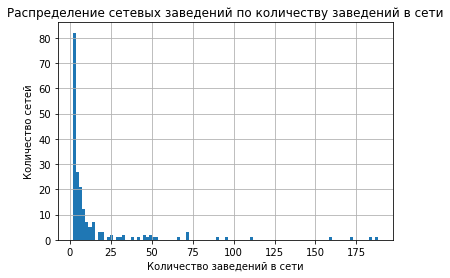

In [23]:
plt.hist(rest_data_chains['object_name_lower'].value_counts(), bins=100)
plt.grid()
plt.title('Распределение сетевых заведений по количеству заведений в сети')
plt.ylabel('Количество сетей')
plt.xlabel('Количество заведений в сети')
plt.show()

In [24]:
print('Максимальное количество заведений в сети:',
      rest_data[rest_data['chain']=='да']['object_name_lower'].value_counts()[0])

Максимальное количество заведений в сети: 188


Наибольшее количество сетей имеет до 20 заведений, но есть и большие сети до 188 заведений в сети.

Рассмотрим среднее количество посадочных мест в заведении по сетям.

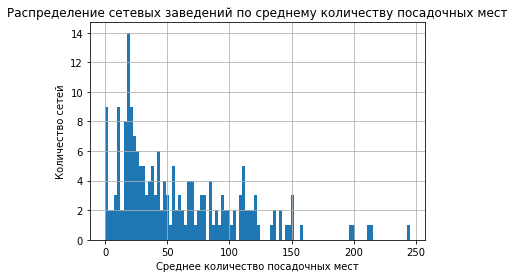

In [25]:
plt.hist(rest_data_chains.pivot_table(index='object_name_lower', values='number'), bins=100)
plt.grid()
plt.title('Распределение сетевых заведений по среднему количеству посадочных мест')
plt.ylabel('Количество сетей')
plt.xlabel('Среднее количество посадочных мест')
plt.show()

У наибольшего количества сетей среднее количество посадочных мест в сети не превышает 50, однако есть сети со средним количеством посадочных мест более 300.

Посмотрим, есть ли зависимость среднего количества посадочных мест от количества заведений в сети. 

In [26]:
#вынесем в отдельный датафрейм количество заведений и среднее количество посадочных мест в заведениях сети
count_and_number_chains = rest_data_chains.pivot_table(index='object_name_lower',
                                                      aggfunc={'id':'count', 'number':'mean'})\
                                            .rename(columns={'id':'count', 'number':'mean_number'})

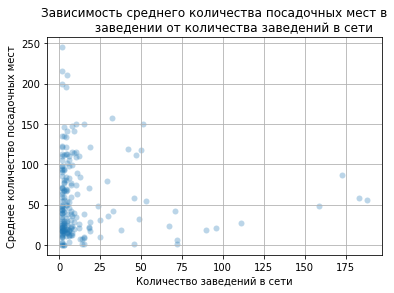

In [27]:
sns.scatterplot(x="count", y="mean_number",
linewidth=0, alpha=0.3,
data=count_and_number_chains)
plt.title('''Зависимость среднего количества посадочных мест в
          заведении от количества заведений в сети''')
plt.xlabel('Количество заведений в сети')
plt.ylabel('Среднее количество посадочных мест')
plt.grid()
plt.show()

In [28]:
print('Корреляция среднего количества посадочных мест в сети от количества заведений в сети:',
     round(count_and_number_chains['mean_number'].corr(count_and_number_chains['count']),3))

Корреляция среднего количества посадочных мест в сети от количества заведений в сети: -0.038


Корреляция среднего количества посадочных мест в сети от количества заведений в сети отсутствует, тем не менее по графику можно сделать выводы:
- большое среднее количество посадочных мест имеют небольшие сети до 10 заведений;
- вне зависимости от количества заведений в сети преобладают сети со средним количеством посадочных мест до 150. 

<span style="color: blue">Разделим сети на 4 категории:
- с небольшим количеством заведений и небольшим количеством посадочных мест;
- с небольшим количеством заведений и большим количеством посадочных мест;
- с большим количеством заведений и небольшим количеством посадочных мест;
- с большим количеством заведений и большим количеством посадочных мест.

Примем значение как большое, если оно больше 75% остальных значений. Для этого посчитаем третий квартиль для среднего количества посадочных мест и количества заведений в сети.</span>

In [29]:
many_rests = round(np.percentile(count_and_number_chains['count'], 75), 0)
many_seats = round(np.percentile(count_and_number_chains['mean_number'], 75), 0)
many_rests, many_seats

(10.0, 85.0)

In [30]:
def chain_class(row):
    count = row['count']
    mean_number = row['mean_number']
    if (count < many_rests) and (mean_number < many_seats):
        return('немного заведений, немного мест')
    elif (count < many_rests) and (mean_number >= many_seats):
        return('немного заведений, много мест')
    elif (count >= many_rests) and (mean_number < many_seats):
        return('много заведений, немного мест')
    else:
        return('много заведений, много мест')        

In [31]:
count_and_number_chains['chain_class'] = count_and_number_chains.apply(chain_class, axis=1)

In [32]:
count_and_number_chains.chain_class.value_counts()/len(count_and_number_chains)

немного заведений, немного мест    0.546392
много заведений, немного мест      0.201031
немного заведений, много мест      0.185567
много заведений, много мест        0.067010
Name: chain_class, dtype: float64

<span style="color: blue">C вероятностью 55% случайно выбранная сеть будет небольшой (до 10 заведений) с небольшим средним количеством посадочных мест (до 85).</span>

<a id="mean_by_type"></a>
### Среднее количество посадочных мест по видам объекта общественного питания

Посчитаем среднее количество посадочных мест для каждого вида объекта общественного питания.

In [33]:
rest_data.groupby('object_type')['number'].agg('median').sort_values(ascending=False)

object_type
столовая                             103.0
ресторан                              80.0
бар                                   35.0
буфет                                 32.0
кафе                                  30.0
кафетерий                              6.0
предприятие быстрого обслуживания      5.0
закусочная                             0.0
магазин (отдел кулинарии)              0.0
Name: number, dtype: float64

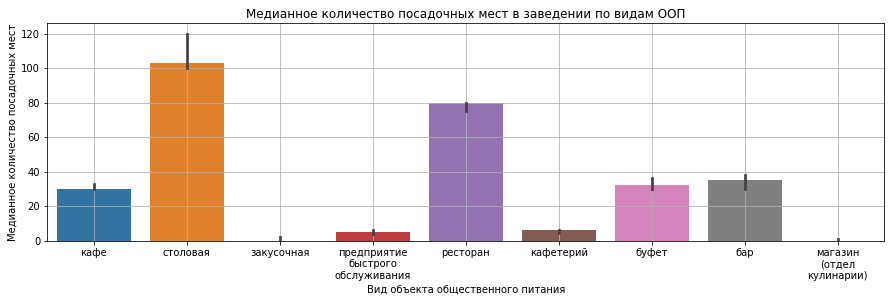

In [34]:
plt.figure(figsize=(15, 4))
sns.barplot(x='object_type', y='number', data=rest_data, estimator=np.median)
plt.title('Медианное количество посадочных мест в заведении по видам ООП')
plt.xlabel('Вид объекта общественного питания')
plt.ylabel('Медианное количество посадочных мест')


old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])


plt.grid()
plt.show()

Наибольшее <span style="color: blue">медианное</span> количество посадочных мест у столовых (<span style="color: blue">103</span>), наименьшее - у отделов кулинарии в магазинах (<span style="color: blue">0</span>).

<a id="10_streets"></a>
### Топ-10 улиц по количеству объектов общественного питания

Выделим названия улиц в отдельную колонку датафрейма. 

Для этого проведем лемматизацию, найдем наиболее распространенные названия улиц (улица, проспект, шоссе), чтобы использовать их как маркеры.

In [35]:
def lemm(df, col):
    df = df.dropna(subset=[col]).reset_index(drop=True)
    lemm_list = []
    for i in range(len(df)):
        lemm_list.append(df.loc[i, col])
    lemm_str = ' '.join(lemm_list)
    m = Mystem()
    lemm_list = m.lemmatize(lemm_str)
    print(Counter(lemm_list))

In [36]:
lemm(rest_data, 'address')

Counter({' ': 72914, ', ': 38404, 'город': 15698, 'москва': 15303, 'дом': 14841, 'улица': 9088, '1': 4636, 'строение': 4154, 'корпус': 2770, '2': 2505, 'проспект': 1481, 'шоссе': 1325, '3': 1263, '-': 1250, '/': 1189, '4': 957, '5': 861, 'проезд': 794, 'бульвар': 754, 'переулок': 725, '6': 683, 'большой': 657, '7': 632, '8': 551, '10': 524, '9': 497, '12': 493, 'я': 470, 'поселение': 420, 'й': 410, '11': 405, 'набережная': 390, 'площадь': 385, '13': 371, '15': 370, '14': 345, '16': 339, 'владение': 309, '22': 306, 'вал': 295, '18': 294, '20': 294, '17': 286, '26': 284, '21': 282, 'ленинградский': 273, '19': 270, 'ленинский': 265, 'зеленоград': 232, '24': 220, '23': 209, '27': 208, 'мир': 204, '25': 194, 'профсоюзный': 183, 'пресненский': 178, 'московский': 172, 'арбат': 169, '32': 169, '29': 168, 'варшавский': 167, '33': 153, 'малый': 152, 'километр': 151, 'маршал': 147, 'сосенский': 141, '36': 139, '28': 137, 'тверской': 136, '30': 133, 'вернадский': 132, 'поселок': 126, '31': 125, '1

In [37]:
def street(address): #напишем функцию для выделения улицы из адреса
    address = address.lower()
    address = address.split(', ')
    if address[1] == 'город зеленоград': # для города Зеленоград если в адресе кроме города есть улица, сохраним и ее
        if 'корпус' not in address[2]:
            street = address[1] + ', ' + address[2]
            return(street)
        street = address[1]
        return(street)
    for part in address:
        for street_name in ['улица', 'проспект', 'шоссе', 'проезд', 'бульвар', 'переулок', 'набережная', 'площадь', 
                            'квартал', 'аллея', 'микрорайон', 'деревня', 'посёлок']:
            if street_name in part:
                return(part)
    return('unknown')

In [38]:
rest_data['street'] = rest_data['address'].map(street)

Создадим датафрейм с количеством объектов общественного питания по улицам.

In [39]:
count_rest_by_streets = rest_data.pivot_table(index='street', values='id', aggfunc='count')\
    .rename(columns={'id':'count'}).sort_values('count', ascending=False)

Найдем топ-10 улиц по количеству объектов общественного питания.

In [40]:
top_ten_streets = count_rest_by_streets.head(10).index #запишем их названия в переменную
count_rest_by_streets.head(10)

,count
street,
проспект мира,204
профсоюзная улица,183
ленинградский проспект,173
пресненская набережная,167
варшавское шоссе,165
ленинский проспект,148
проспект вернадского,132
город зеленоград,129
кутузовский проспект,114


Построим график.

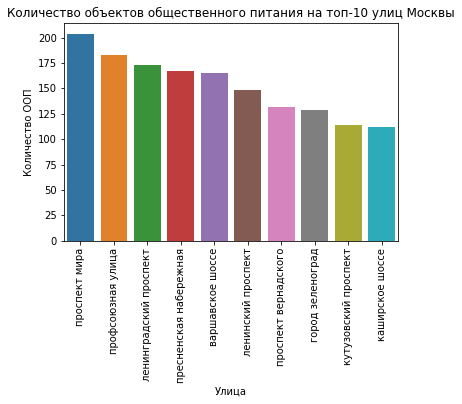

In [41]:
sns.barplot(data=count_rest_by_streets[count_rest_by_streets.index.isin(count_rest_by_streets.head(10).index)],
             x=count_rest_by_streets.head(10).index,
            y='count')
plt.title('Количество объектов общественного питания на топ-10 улиц Москвы')
plt.ylabel('Количество ООП')
plt.xlabel('Улица')
plt.xticks(rotation=90)
plt.show()

Посмотрим, в каких районах находятся эти улицы.

Для этого воспользуемся внешним ресурсом - базой улиц Мосгаз.

In [42]:
mos_gaz = pd.read_csv(
    'https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv?sequence=1&isAllowed=y')

description([mos_gaz], ['mos_gaz'])

Первые 5 строк и сводная информация по файлу mos_gaz


,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   streetname  4398 non-null   object
 1   areaid      4398 non-null   int64 
 2   okrug       4398 non-null   object
 3   area        4398 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB
Количество строк-дубликатов в датафрейме mos_gaz равно 8
____________________________________________________________________________________________________


Датафрейм не имеет пропусков. Есть дубликаты, но они нам не помешают.

In [43]:
mos_gaz['streetname'] = mos_gaz['streetname'].map(str.lower) #приведем названия улиц к нижнему регистру

Найдем районы, в которых проходят улицы топ-10 по количеству объектов общественного питания. Сюда нужно добавить город Зеленоград, так как большая часть зданий Зеленограда не имеет улицы, адрес состоит только из названия города и номера корпуса.

In [44]:
mos_gaz[mos_gaz['streetname'].isin(count_rest_by_streets.head(10).index)]['area'].unique()

array(['Пресненский район', 'Район Дорогомилово', 'Район Фили-Давыдково',
       'Район Проспект Вернадского', 'Район Раменки',
       'Район Тропарево-Никулино', 'Район Крюково',
       'Район Матушкино-Савелки', 'Панфиловский район', 'Район Аэропорт',
       'Район Беговой', 'Хорошевский район', 'Район Сокол',
       'Алексеевский район', 'Ярославский Район', 'Район Марьина роща',
       'Останкинский район', 'Район Ростокино', 'Район Свиблово',
       'Район Чертаново Центральное', 'Район Чертаново Северное',
       'Район Чертаново Южное', 'Донской район',
       'Район Москворечье-Сабурово', 'Район Нагатино-Садовники',
       'Нагорный район', 'Район Орехово-Борисово Южное',
       'Район Орехово-Борисово Северное', 'Академический район',
       'Район Черемушки', 'Район Гагаринский', 'Район Ясенево',
       'Район Коньково', 'Ломоносовский район', 'Обручевский район',
       'Район Северное Бутово', 'Район Теплый Стан', 'Район Южное Бутово',
       'Район Якиманка', 'Мещанский ра

Добавим к датасету с количеством заведений по улицам районы, через которые эти улицы проходят.

In [45]:
count_rest_by_streets = count_rest_by_streets.merge(
    mos_gaz[['streetname', 'area']], how='left', left_index=True, right_on='streetname')

Посмотрим, через какие районы проходят улицы из топ-10.

In [46]:
count_rest_by_streets[count_rest_by_streets['streetname'].isin(top_ten_streets)]

,count,streetname,area
2293.0,204,проспект мира,Алексеевский район
2390.0,204,проспект мира,Ярославский Район
2531.0,204,проспект мира,Район Марьина роща
2578.0,204,проспект мира,Останкинский район
2644.0,204,проспект мира,Район Ростокино
2712.0,204,проспект мира,Район Свиблово
4334.0,204,проспект мира,Мещанский район
3845.0,183,профсоюзная улица,Академический район
3867.0,183,профсоюзная улица,Район Черемушки
3916.0,183,профсоюзная улица,Район Ясенево


Посмотрим количество районов, через которые проходит каждая из топ-10 улиц.

In [47]:
count_rest_by_streets[count_rest_by_streets['streetname'].isin(top_ten_streets)]['streetname'].value_counts()

варшавское шоссе          8
ленинский проспект        8
проспект мира             7
профсоюзная улица         6
проспект вернадского      5
ленинградский проспект    4
каширское шоссе           4
город зеленоград          3
кутузовский проспект      2
пресненская набережная    1
Name: streetname, dtype: int64

In [48]:
print('Медианное количество районов, через которые проходит одна улица:',
      round(count_rest_by_streets['streetname'].value_counts().median(), 1))

Медианное количество районов, через которые проходит одна улица: 1.0


<span style="color: blue">Судя по тому, что медианное количество районов, через которые проходит одна улица в Москве равно 1, а улицы из топ-10, кроме Пресненской набережной, проходят через 2 района и более, можно сделать вывод о том, что большая часть улиц из топ-10 более протяженнее, чем как минимум 50% улиц Москвы.</span>

<a id="streets_one_object"></a>
### Улицы с одним объектом общественного питания

Посмотрим количество улиц с одним объектом общественного питания.

In [49]:
print('Количество улиц с одним объектом общественного питания:',
      (count_rest_by_streets[count_rest_by_streets['count']==1]['streetname'].nunique()))

Количество улиц с одним объектом общественного питания: 563


Посмотрим, в каких районах Москвы находятся эти улицы.

In [50]:
mos_gaz[mos_gaz['streetname'].isin(
    count_rest_by_streets[count_rest_by_streets['count']==1]['streetname'].unique())]['area'].unique()

array(['Пресненский район', 'Таганский район', 'Тверской район',
       'Район Арбат', 'Район Замоскворечье', 'Район Богородское',
       'Район Гольяново', 'Район Измайлово', 'Район Косино-Ухтомский',
       'Басманный район', 'Район Метрогородок', 'Район Новогиреево',
       'Район Перово', 'Район Преображенское', 'Район Северное Измайлово',
       'Район Соколиная Гора', 'Район Восточное Измайлово',
       'Район Восточный', 'Район Ивановское', 'Район Сокольники',
       'Район Дорогомилово', 'Район Филевский Парк',
       'Район Фили-Давыдково', 'Район Кунцево', 'Можайский Район',
       'Район Ново-Переделкино', 'Район Очаково-Матвеевское',
       'Район Раменки', 'Район Солнцево', 'Район Внуково',
       'Район Крюково', 'Район Матушкино-Савелки', 'Район Аэропорт',
       'Район Беговой', 'Бескудниковский Район', 'Дмитровский район',
       'Головинский район', 'Хорошевский район', 'Район Коптево',
       'Район Левобережный', 'Молжаниновский район', 'Савеловский район',
       '

In [51]:
print('Улицы с одним объектом общественного питания расположены в {0} районах Москвы из {1} существующих'\
      .format(
    mos_gaz[mos_gaz['streetname'].isin(
    count_rest_by_streets[count_rest_by_streets['count']==1]['streetname'].unique())]['area'].nunique(),
             mos_gaz['area'].nunique()))

Улицы с одним объектом общественного питания расположены в 100 районах Москвы из 123 существующих


In [52]:
count_rest_by_streets[count_rest_by_streets['count']==1]['area'].value_counts().head()

Район Хамовники      26
Таганский район      25
Басманный район      24
Тверской район       20
Пресненский район    19
Name: area, dtype: int64

<span style="color: blue">Районы с наибольшим количеством улиц с одним объектом общественного питания - это районы в самом центре Москвы в пределах Садового кольца.</span>

<a id="seats_top_10_streets"></a>
### Количество посадочных мест на улицах с большим количеством объектов общественного питания

Рассмотрим, как распределены средние количества посадочных мест в заведениях на улицах в большим количеством объектов общественного питания.

За улицы с большим количеством примем улицы, на которых объектов общественного питания не меньше, чем у 75% остальных улиц. Для начала определим, сколько объектов общественного питания на этих улицах.

In [53]:
print("""Примем за улицы с большим количеством объектов общественного питания улицы, 
на которых количество объектов общественного питания более""", int(np.percentile(count_rest_by_streets['count'], 75)))

Примем за улицы с большим количеством объектов общественного питания улицы, 
на которых количество объектов общественного питания более 10


Вынесем информацию о количестве заведений на этих улицах и среднем количестве посадочных мест в заведении в отдельный датафрейм.

In [54]:
big_streets = rest_data.pivot_table(
    index='street', aggfunc={'id':'count', 'number':'mean'})\
    .rename(columns={'id':'count', 'number':'mean_number'})\
    .sort_values('count', ascending=False)
big_streets = big_streets[big_streets['count']>7]

Построим график зависимости среднего количества посадочных мест в заведении от количества заведений на улице.

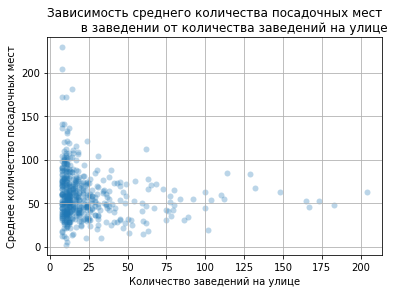

In [55]:
sns.scatterplot(x="count", y="mean_number",
linewidth=0, alpha=0.3,
data=big_streets)
plt.title('''Зависимость среднего количества посадочных мест
          в заведении от количества заведений на улице''')
plt.xlabel('Количество заведений на улице')
plt.ylabel('Среднее количество посадочных мест')
plt.grid()
plt.show()

В целом для улиц с большим количеством объектов общественного питания можно сделать похожие выводы о распределении объектов по количеству посадочных мест: большее количество заведений имеет до 100 посадочных мест, большее количество улиц имеет до 50 заведений. Большие средние количества мест характерны для улиц с небольшим количеством заведений (там меньше влияние большого количества мелких заведений).

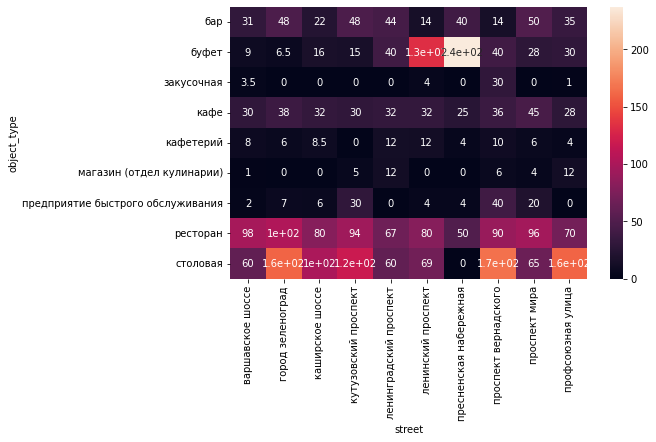

In [56]:
plt.figure(figsize=(8, 5))  
sns.heatmap(rest_data[rest_data['street'].isin(top_ten_streets)].pivot_table(
    index='object_type', columns='street', values='number', aggfunc='median', fill_value=0), annot=True)
plt.show()

<span style="color: blue">Наибольшее медианное количество посадочных мест в объектах общественного питания из списка улиц топ-10 в буфетах на Ленинском проспекте и Пресненской набережной, а также (ожидаемо) в ресторанах и столовых.</span>

<a id="analysis_conclusion"></a>
### Вывод

Наиболее распространенные заведения в Москве - кафе, за ними - столовые, рестораны и предприятия быстрого питания. Сетевые распространены реже, чем несетевые, их количество менее 20%. Наиболее часто сетевые заведения встречаются среди предприятий быстрого обслуживания (41%), отделов кулинарии в магазинах (29%), ресторанов и кафе (24 и 23% соответственно). 


Среди сетей общественного питания чаще встречаются сети с количеством заведений до 20 со средним количеством посадочных мест до 150, однако встречаются большие сети с количеством заведений до 188 - среднее количество посадочных мест в таких сетях не превышает 100, и сети с большим средним количеством посадочных мест - свыше 300 - однако такие сети имеют не более 3 заведений.


По видам объекта общественного питания наибольшее среднее количество посадочных мест имеют столовые (130) и рестораны (96).


Наибольшее количество заведений расположены на улицах: проспект Мира, Профсоюзная, Ленинградский проспект, Пресненская набережная, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект и Каширское шоссе, а также в городе Зеленоград. Возможно, это обусловлено протяженностью улиц (большая часть из них растянута в направлении от Садового кольца к ТКК) и большой проходимостью (на данных улицах большое количество не только заведений питания, но и мест работы и учебы). <br>
Данные улицы расположены в центре Москвы и прилегающих районах, однако в этих же районах можно найти и улицы с одним объектом общественного питания.


Распределение среднего количества посадочных мест в объектах общественного питания по улицам в зависимости от количества объектов общественного питания на улице похоже на распределение среднего количества посадочных мест в заведениях сети от размера сети: на улицах с большим количеством заведений среднее количество посадочных мест не превышает 100, на улицах с большим средним количеством посадочных мест количество заведений не более 10, большая часть улиц имеет не более 75 заведений и среднее количество посадочных мест не более 150. 

<a id="conclusion"></a>
## Общий вывод

Проведен анализ открытых данных о заведениях общественного питания в Москве.

Данные получены в виде датасета с информацией: идентификатор объекта общественного питания, его название, указание, является ли объект сетевым, тип объекта, его адрес и количество посадочных мест.

В ходе предобработки добавлена колонка с названием заведения в нижнем регистре, названия сетей скорректированы в соответствии с данными датасета moscow_rest_chains.csv.

При анализе установлено:
- наиболее распространенные заведения в Москве - кафе, за ними - столовые, рестораны и предприятия быстрого питания, сетевых заметно меньше, чем несетевые, сетевыми чаще являются предприятия быстрого обслуживания, отделы кулинарии в магазинах, рестораны и кафе;
- среди сетей общественного питания наиболее распространены сети со средним количеством посадочных мест до 150 и количеством заведений до 20;
- наибольшее среднее количество посадочных мест имеют столовые и рестораны;
- наибольшее количество заведений расположены на центральных улицах Москвы;
- улицы с наибольшим количеством заведений общественного питания имеют до 10 заведений и среднее количество посадочных мест в заведениях до 150. 
---
**Рекомендации**

Кафе лучше открыть на одной из центральных улиц с большой проходимостью, количество посадочных мест определить <span style="color: blue">от 15 до 50</span>.

---

<a href='https://drive.google.com/file/d/10pLNxdcSwrJnRHcG4fVgCzA42BXYwqAs/view?usp=sharing'>Презентация</a>